# Answering Business Questions using SQL

We'll be working with a modified (by [Dataquest](https://dataquest.io/)) version of a database called [Chinook](https://github.com/lerocha/chinook-database). 
The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.
The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases.
Here's a schema diagram for the Chinook database:

![Chinook_Schema](chinook-schema.svg "Chinook_Schema")


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(query)

## Table name

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Which genres sell the most tracks?

In [4]:
# a query that returns each genre, with  
# the number of tracks sold in the USA
q1 = '''
WITH genre_info AS
(
    SELECT 
        i.track_id, 
        i.quantity,
        t.genre_id,
        g.name genre
    FROM invoice_line i
    LEFT JOIN track t ON t.track_id = i.track_id
    LEFT JOIN genre g ON g.genre_id = t.genre_id
)

SELECT 
    genre, 
    SUM(quantity) track_sold,
    CAST(SUM(quantity) AS float) / (SELECT SUM(quantity) FROM genre_info) track_sold_percentage
FROM genre_info
GROUP BY genre
ORDER BY track_sold DESC
'''
run_query(q1)

,genre,track_sold,track_sold_percentage
0,Rock,2635,0.553921
1,Metal,619,0.130124
2,Alternative & Punk,492,0.103427
3,Latin,167,0.035106
4,R&B/Soul,159,0.033424
5,Blues,124,0.026067
6,Jazz,121,0.025436
7,Alternative,117,0.024595
8,Easy Listening,74,0.015556
9,Pop,63,0.013244


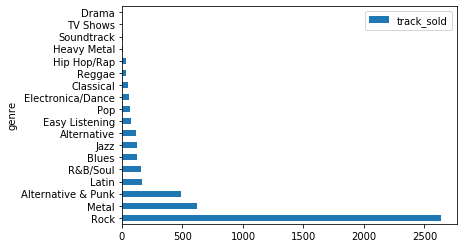

In [5]:
genre_sales_usa = run_query(q1)
genre_sales_usa = genre_sales_usa.set_index('genre')
genre_sales_usa.plot.barh(y='track_sold', rot=0)

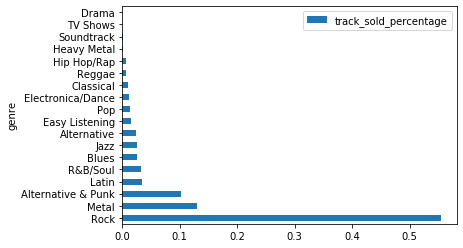

In [6]:
genre_sales_usa.plot.barh(y='track_sold_percentage', rot=0)

Top 3 genre:
1. Rock
2. Metal
3. Alternative & Punk

In [7]:
# a query that finds the total dollar amount of sales 
# assigned to each sales support agent within the company
q2 = '''
WITH sales_performance AS
(
    SELECT 
        c.customer_id,
        c.first_name || " " || c.last_name customer_name,
        SUM(i.total) total_purchase,
        e.employee_id,
        e.first_name || " " || e.last_name employee_name,
        e.hire_date
    FROM customer c
    LEFT JOIN employee e ON e.employee_id = c.support_rep_id
    LEFT JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY employee_name
)

SELECT 
    employee_name, 
    total_purchase, 
    hire_date FROM sales_performance
ORDER BY total_purchase DESC
'''
run_query(q2)

,employee_name,total_purchase,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


Only 3 sales support agent.

In [8]:
c = '''
CREATE VIEW top_5_names AS
     SELECT
         first_name,
         count(customer_id) count
     FROM customer
     GROUP by 1
     ORDER by 2 DESC
     LIMIT 5;
'''
run_command(c)

q = 'SELECT * FROM top_5_names;'
run_query(q)

,first_name,count
0,Mark,2
1,Frank,2
2,Wyatt,1
3,Victor,1
4,Tim,1


In [9]:
q3 = '''
SELECT
    first_name,
    count
FROM
    (
    SELECT
        t5.*,
        CASE
            WHEN t5.first_name = "Mark" THEN 1
            ELSE 0
        END AS sort
    FROM top_5_names t5
   )
ORDER BY sort ASC
'''
run_query(q3)

,first_name,count
0,Frank,2
1,Wyatt,1
2,Victor,1
3,Tim,1
4,Mark,2
